In [2]:
! pip install -q lmfit 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit 
import pandas as pd
import re

In [4]:
# extract data from the 2011 
data=pd.read_csv('SCPUnion2.1_AllSNe.txt', sep=' & ', dtype='object')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [5]:
print(data.columns)
data = data[data['status'] != r'f\\']       # remove failed data
print(data)

Index(['Name', 'RedShift', 'B-Band Magnitude', 'Stretch', 'Color',
       'Distance Modulus', 'Sample', 'CutsFailed', 'status'],
      dtype='object')
       Name RedShift B-Band Magnitude  ... Sample CutsFailed     status
0    1993ah   0.0285      16.86(0.19)  ...  0.128          1  \nodata\\
1    1993ag   0.0500      17.79(0.05)  ...  0.128          1  \nodata\\
2     1993o   0.0529      17.60(0.05)  ...  0.128          1  \nodata\\
3     1993b   0.0701      18.43(0.04)  ...  0.128          1  \nodata\\
4    1992bs   0.0627      18.25(0.05)  ...  0.128          1  \nodata\\
..      ...      ...              ...  ...    ...        ...        ...
744   D-000   1.0170      25.20(0.12)  ...  0.000         19  \nodata\\
745   D-006   1.3150      25.68(0.13)  ...  0.552         19  \nodata\\
746   P-009   0.8210      24.37(0.09)  ...  0.552         19  \nodata\\
747   R-012   1.2150      25.79(0.16)  ...  0.000         19  \nodata\\
748   Z-005   0.6230      23.48(0.15)  ...  0.552        

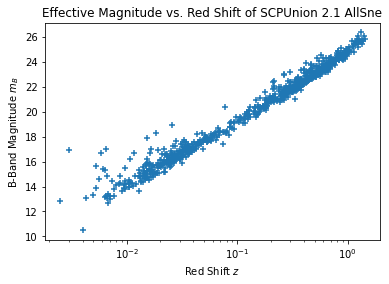

In [6]:
magB = data['B-Band Magnitude'].values.tolist()
magB_exact = []
for i in magB:
    exact = re.sub(r"\([^()]*\)", "", i)
    try:
        magB_exact.append(float(exact))
    except:
        magB_exact.append(0)
redShift = data['RedShift'].values.tolist()
redShift_exact = []
for i in redShift:
    exact = re.sub(r"\([^()]*\)", "", i)
    try:
        redShift_exact.append(float(exact))
    except:
        redShift_exact.append(0)

plt.scatter(redShift_exact, magB_exact, marker='+')
plt.xscale('log')
plt.xlabel(r'Red Shift $z$')
plt.ylabel(r'B-Band Magnitude $m_B$')
plt.title('Effective Magnitude vs. Red Shift of SCPUnion 2.1 AllSne')
plt.show()

##### low red shift data:

In [7]:
# obtain low red shift data
redShift_float = np.float_(redShift_exact); magB_float = np.float_(magB_exact)        # convert all values to float
redShift_low_position = np.where(redShift_float <= 0.1)       # get all low red shift positions
redShift_low = redShift_float[redShift_low_position]          # get low red shift values on those positions
magB_low = magB_float[redShift_low_position]

redShift_high_position = np.where(redShift_float > 0.1)
redShift_high = redShift_float[redShift_high_position]
magB_high = magB_float[redShift_high_position]

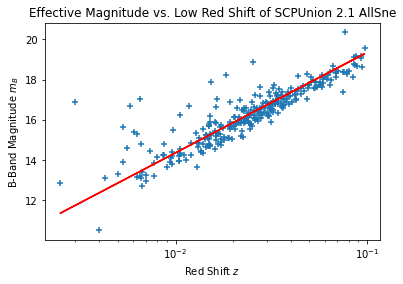

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 286
    # variables        = 1
    chi-square         = 159.004419
    reduced chi-square = 0.55791024
    Akaike info crit   = -165.899108
    Bayesian info crit = -162.243116
[[Variables]]
    absMag: -18.0265112 +/- 0.04416713 (0.25%) (init = 0)


In [28]:
# now we do a linear fit 
from lmfit import minimize, Parameters, Parameter, report_fit

def residual(ps, magEff, z):
    M_c = ps['absMag'].value
    c = 3*10**8           # speed of light 
    model = M_c + 5*np.log10(c*z)
    return (model - magEff).ravel()

params = Parameters()
params.add('absMag', value = 0)        # set the chirp mass as the only variable

result_fit = minimize(residual, params, args=(magB_low, redShift_low), method='leastsq')
final_fit = magB_low + result_fit.residual.reshape(magB_low.shape)

plt.scatter(redShift_low, magB_low, marker='+')       # original low red shift data
plt.plot(redShift_low, final_fit, c='r')       # fitted magB value combined with original low red shift data
plt.xscale('log')
plt.xlabel(r'Red Shift $z$')
plt.ylabel(r'B-Band Magnitude $m_B$')
plt.title('Effective Magnitude vs. Low Red Shift of SCPUnion 2.1 AllSne')
plt.show()

report_fit(result_fit)

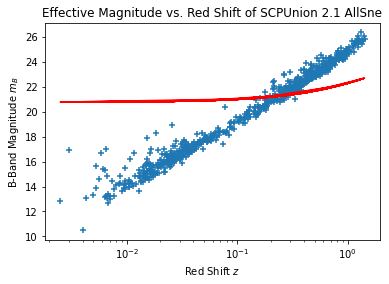

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 714
    # variables        = 2
    chi-square         = 7697.75262
    reduced chi-square = 10.8114503
    Akaike info crit   = 1701.74973
    Bayesian info crit = 1710.89149
[[Variables]]
    omegaM:  9.99985487 +/- 53705516.3 (537062957.40%) (init = 0)
    omegaD: -1.27607864 +/- 7343772.96 (575495329.89%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(omegaM, omegaD) = 1.000


In [58]:
from scipy import integrate

def residual(ps, magEff, z):
    M_c = -18.0265112 #Best value of modified magnitude
    omegaM = ps['omegaM'].value
    omegaD = ps['omegaD'].value
    tegral = lambda x: 1/(np.sqrt(omegaM*(1+x)**3 + omegaD)) #integral portion of assignment eq.5
    integra, err = integrate.quad(tegral, 0, z.all())
    c = 3*10**8           # speed of light 
    model = M_c + 5*np.log10(c*(1+z)*integra) #Equation 1
    return (model - magEff).ravel()

params = Parameters()
params.add('omegaM', min=0, max=10)        # set the energy densities as variables
params.add('omegaD', value=0.00001, max=10)

result_fit = minimize(residual, params, args=(magB_float, redShift_float), method='leastsq')
final_fit = magB_float + result_fit.residual.reshape(magB_float.shape)

plt.scatter(redShift_float, magB_float, marker='+')       # original red shift data
plt.plot(redShift_float, final_fit, c='r')       # fitted magB value combined with original red shift data
plt.xscale('log')
plt.xlabel(r'Red Shift $z$')
plt.ylabel(r'B-Band Magnitude $m_B$')
plt.title('Effective Magnitude vs. Red Shift of SCPUnion 2.1 AllSne')
plt.show()

report_fit(result_fit)